_Version log: Optimisation using Simulated Annealing._

In [192]:
import sys, warnings
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as spimg
from scipy import fft as spfft
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [193]:
def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward")

    return result


def subsample_1d(total_points, subsampling_percentage = 0.5, subsampling_method = "random"):

    if subsampling_method == "random":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)

    if subsampling_method == "regular":
        reduced_points = round(total_points *subsampling_percentage)
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
     
    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

In [194]:
file_name = "1dmock3"
file_type = ".csv"

target = open_dataset(file_name, file_type)
total_points = len(target)

In [195]:
iterations = 5000
max_temp = 100
cooling = 0.99
subsample_percentage = 0.05
regularization_coeffient = 1e-4 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)

reduced_points = round(total_points *subsample_percentage)
detectors = original_detectors = subsample_1d(total_points, subsample_percentage, "regular")

print(total_points, reduced_points)

320 16


In [196]:
#########INITAILISATION##########

scores = np.array([])
temps = []

result = compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)
score = np.linalg.norm(target -result)

target_temp = max_temp
improvement = True

#######START SIMULATED ANNEALLING###########

for n in tqdm(range(iterations)):

    #target_temp = max_temp *cooling**n +1

    valid_vector_found = False
    while not valid_vector_found:
        temprature = target_temp
        random_vector = np.random.rand(reduced_points) -0.5
        random_vector /= np.linalg.norm(random_vector)
        random_step = random_vector *temprature
        new_detectors = np.round(detectors +random_step).astype(int)

        while 0 < temprature:
            bounds = np.concatenate([0 <= new_detectors, new_detectors < total_points, np.diff(new_detectors) > 0]) #, new_detectors != detectors]) #The last requirement that the new detectors must not be the same as the old ones makes it much slower.
            if np.all(bounds):
                valid_vector_found = True
                break
            temprature -= 0.2
            random_step = random_vector *temprature
            new_detectors = np.round(detectors +random_step).astype(int)


    new_result = compressed_sensing(target[new_detectors], new_detectors, total_points, regularization_coeffient)

    new_score = np.linalg.norm(target -new_result)

    if new_score < score:
        detectors = new_detectors
        result = new_result
        score = new_score
        improvement = True

    if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
        target_temp = max_temp
        improvement = False
    elif improvement: #When hot, stop exploring and start optimising this regime.
        target_temp *= cooling

    scores = np.append(scores, score)
    temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors)]]

temps = np.array(temps).T

  0%|          | 5/5000 [00:00<03:50, 21.67it/s]

100%|██████████| 5000/5000 [02:01<00:00, 41.05it/s]


In [197]:
frequent_temps = np.array(np.unique(temps[1], return_counts=True)).T
frequent_temps = frequent_temps[frequent_temps[:, 1].argsort()[::-1]]
frequent_temps[:5]

array([[  0.        , 452.        ],
       [  2.82842712, 203.        ],
       [  2.44948974, 195.        ],
       [  3.        , 194.        ],
       [  2.23606798, 187.        ]])

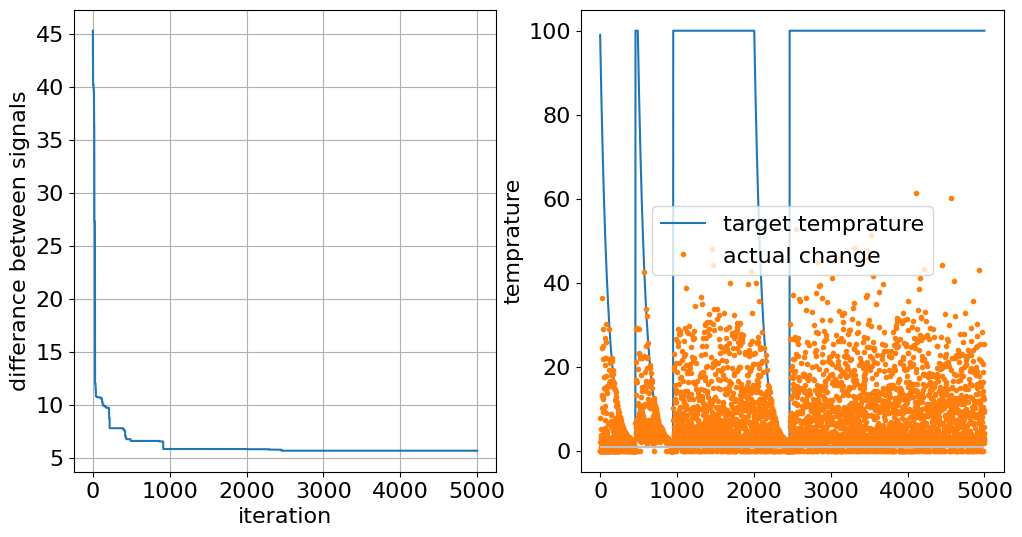

In [198]:
fig, axs = plt.subplots(1,2, figsize= (12,6))

axs[0].plot(scores)
axs[0].grid(True)
axs[0].set(ylabel= "differance between signals", xlabel= "iteration")

axs[1].plot(temps[0], label= "target temprature") #target temprature
axs[1].plot(temps[1], marker= ".", linestyle= "None", label= "actual change") #actual temprature due to bounds constraints.
axs[1].hlines(1, 0, iterations, color= "silver")
axs[1].set(ylabel= "temprature", xlabel= "iteration")
axs[1].legend()

plt.show()

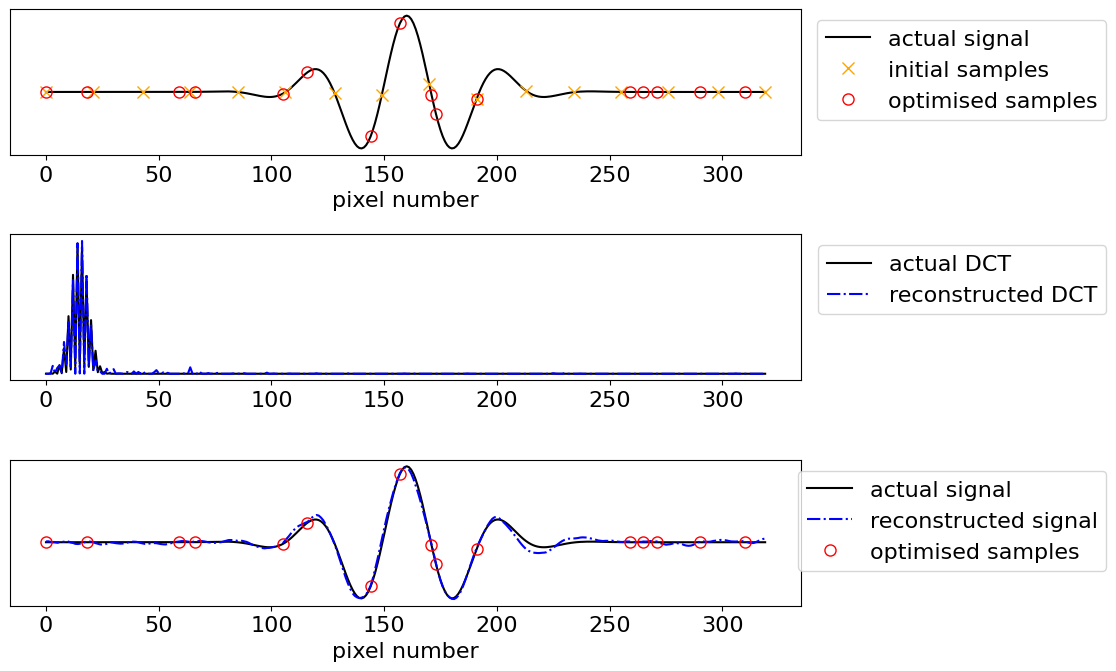

In [199]:
result_DCT = spfft.dct(result, norm= "forward")
target_DCT = spfft.dct(target, norm= "forward")


plt.rcParams.update({'font.size':16})
fig, axs = plt.subplots(3,1, figsize= (12,7))

axs[0].plot(target, color= "k", label= "actual signal")
axs[0].plot(original_detectors, target[original_detectors], marker= "x", markerfacecolor= "None", markersize= 8, color= "orange", linestyle= "None", label= "initial samples")
axs[0].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[0].set(xlabel= "pixel number")

axs[1].plot(np.abs(target_DCT), color= "k", label= "actual DCT")
axs[1].plot(np.abs(result_DCT), color= "blue", label= "reconstructed DCT", linestyle= "-.")

axs[2].plot(target, color= "k", label= "actual signal")
axs[2].plot(result, color= "blue", label= "reconstructed signal", linestyle= "-.")
axs[2].plot(detectors, target[detectors], marker= "o", markerfacecolor= "None", markersize= 8, color= "red", linestyle= "None", label= "optimised samples")
axs[2].set(xlabel= "pixel number")

[ax.legend(loc= 'upper right', bbox_to_anchor=(1.4, 1)) for ax in axs]
[ax.set(yticks= []) for ax in axs]

plt.tight_layout()
plt.show()

In [200]:
optlocs_file = "data\\" + file_name +"_optlocs.csv"

with open(optlocs_file, 'a') as file: #chat gpt did this bit for me.
    # Add data to a new line
    detectors_string = np.array2string(detectors, separator=',').replace('\n', '')[1:-1]
    file.write(detectors_string +"\n")
    file.close()


In [201]:
#I'm surprised that numpy and scipy don't have meathods for reading files with inconsistant numbers of delimiters.

with open(optlocs_file, 'r') as file:
    lines = [line[:-2] for line in list(file)]
    number_of_delimiters = [line.count(",") for line in lines]
    max_delimiters = max(number_of_delimiters)
    missing_delimiters = [max_delimiters -delimiters for delimiters in number_of_delimiters]
    data = [line.split(",") for line in lines]
    data = [[int(datapoint) for datapoint in line] for line in data] #2D list comprehention!!!!
    full_data = [data[n] + [np.nan]*missing_delimiters[n] for n in range(len(lines))]
    full_data = np.array(full_data)
    file.close()

print(len(lines))

11


In [202]:
frequent_locs = np.array(np.unique(full_data, return_counts=True)).T
frequent_locs = frequent_locs[:-1] #remove nans
frequent_locs = frequent_locs[frequent_locs[:, 1].argsort()[::-1]]
print(frequent_locs[:5])
frequent_locs = [frequent_locs[frequent_locs[:,0].tolist().index(n),1] if n in frequent_locs[:,0] else np.nan for n in range(total_points)]

[[ 31.   9.]
 [165.   5.]
 [  0.   3.]
 [ 49.   3.]
 [255.   3.]]


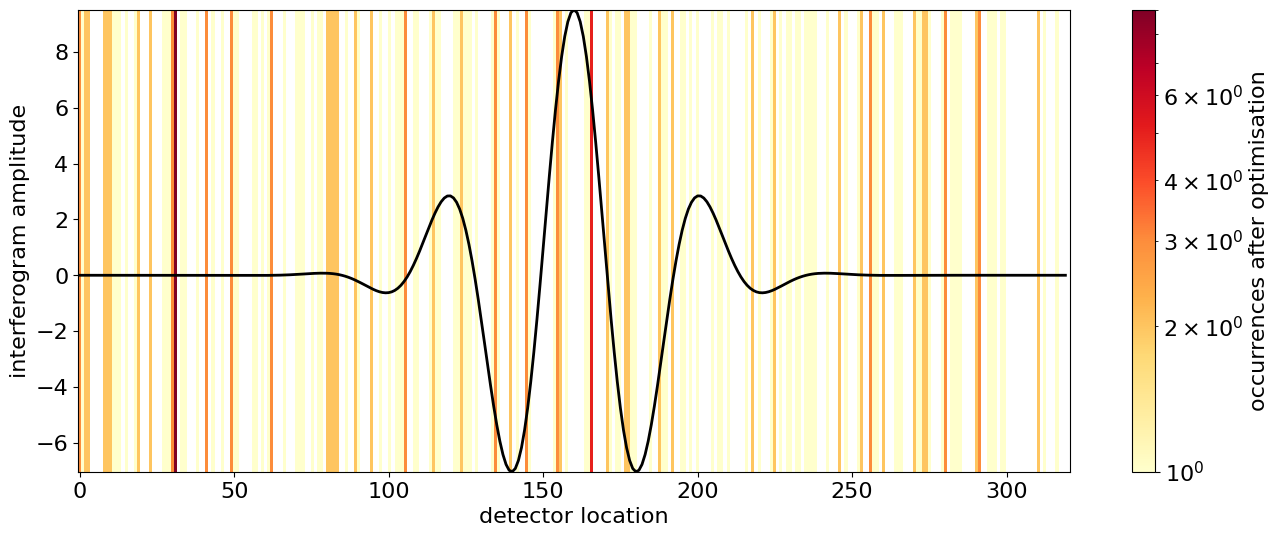

In [203]:
fig, axs = plt.subplots(figsize= (16,6))

axs.plot(target, color= "k", linewidth= 2, label= "interferogram")

im = plt.imshow([frequent_locs], aspect= "auto", extent= (-0.5, total_points +0.5, min(target), max(target)), cmap= "YlOrRd", norm= "log")
plt.colorbar(im, label= "occurrences after optimisation")

axs.set(xlabel= "detector location", ylabel= "interferogram amplitude")
plt.show()